# Variational Dicke State Preparation

In [1]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)

swap = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])

C:\Users\Hannah\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
def pswap(theta):
    
    mat = np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])
    
    return mat

In [3]:
def keys(n,k):
    return list 

In [4]:
def DickeCircuit(n,k,theta):
    q = QuantumRegister(4,'q')
    c = ClassicalRegister(4,'c')
    circ = QuantumCircuit(q,c)
    
    circ.h(q[0])
    circ.x(q[1])
    circ.cx(q[0],q[1])

    circ.cx(q[0],q[2])
    circ.cx(q[1],q[3])

    circ.append(two_qubit_decomp(pswap(theta[0])),[q[2],q[3]])
    circ.append(two_qubit_decomp(pswap(theta[1])),[q[1],q[2]])

    circ.cz(q[0],q[1])
    circ.cz(q[1],q[2])

    return circ
    

In [11]:
def DickeCounts(n,k,theta,shots):
    qc = DickeCircuit(n,k,theta)
    qc.measure(range(n),range(n))
    backend      = Aer.get_backend("qasm_simulator")
    simulate     = execute(qc, backend=backend, shots=shots)
    counts = simulate.result().get_counts()
    return counts

In [10]:
def objG(theta,constants):
    n = constants[1]
    k = constants[2]
    shots = constants[0]
    
    num = 3 
        
    keys = ['1100','1010','1001','0110','0101','0011']
    
    counts_dict_list = []
    for i in range(num):
        counts_dict_list.append(DickeCounts(n,k,theta,shots))
  
    
    counts_avg = []    # average of each key 
    for key in keys:  #for each key 
        c_list = []
        for i in range(num):
            if key in counts_dict_list[i].keys():
                c_list.append(counts_dict_list[i][key])
            else:
                c_list.append(0)
        counts_avg.append(np.average(c_list))

    return np.std(counts_avg)
    
    

In [12]:
#prepares a Dicke state with given n and k
#returns the circuit
def Dicke(n,k,shots):
    
    n_theta = 2
    constants = [shots,n,k]

    theta = []
    for i in range(n_theta):
        theta.append(np.random.uniform(0,2*np.pi))

    x_list = []
    def callback(x):
        x_list.append(objG(x,constants))
        itr = np.linspace(1,len(x_list),len(x_list))
        plt.plot(itr,x_list)
        clear_output(wait=True)
        plt.show()

    opt = sp.optimize.minimize(objG, x0=theta, args=constants, method = 'Powell', callback=callback)
    theta_min = opt.x
    print(theta_min)

    counts_best = DickeCounts(n,k,theta_min,shots)
    print(counts_best)

    std_best = objG(theta_min,constants)
    print(std_best)

    ##simulation of the circuit with the right parameters
    return DickeCircuit(n,k,opt.x)

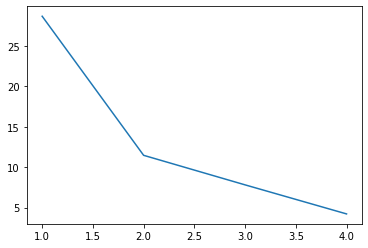

[5.67129642 0.79473452]
{'0011': 182, '0101': 171, '0110': 151, '1001': 183, '1010': 160, '1100': 177}
5.171145012542262


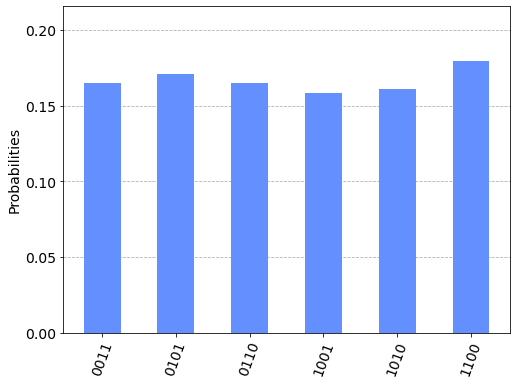

In [13]:
n = 4
k = 2
shots = 1024
qc = Dicke(n,k,1024)
qc.measure(range(n),range(n))
backend      = Aer.get_backend("qasm_simulator")
simulate     = execute(qc, backend=backend, shots=shots)
results = simulate.result()
display (plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False))